In [1]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")
from codebase import get_total_inhabitants_and_willingness, number_of_residents_in_detour, load_buurt_data, read_all_punt_to_punt, make_detour_matrix

Changed to C:\Users\david\PycharmProjects\TUE\Design-of-AI-driven-business-operation


In [2]:
punten = ['basis', 'bus', 'hbo_wo', 'highschool', 'ibis', 'mbo', 'trein']
modes = ['fiets', 'ebike']

matrix_data = read_all_punt_to_punt(punten, modes)


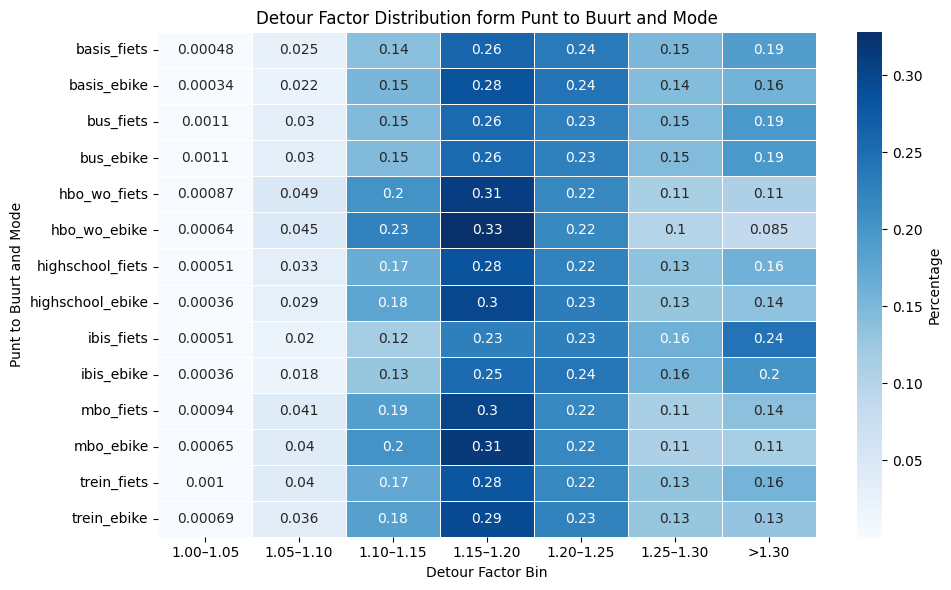

In [3]:
make_detour_matrix(matrix_data)

Loaded file from CSV


C:\Users\david\AppData\Local\Temp\ipykernel_2548\2125765406.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum()


CSV saved → detour_trein_fiets.csv
                gm_naam  pop_weighted_detour
144               Hulst             2.431832
268           Terneuzen             2.012440
269        Terschelling             1.846487
296            Vlieland             1.801895
14              Ameland             1.627701
249     Schiermonnikoog             1.605260
231         Reimerswaal             1.604377
46              Borsele             1.598054
148             Kapelle             1.499319
102  Goeree-Overflakkee             1.456277
250  Schouwen-Duiveland             1.434147
103                Goes             1.433284
309           Waterland             1.394955
83        Edam-Volendam             1.392916
272              Tholen             1.382385
10               Almere             1.367893
255               Sluis             1.358277
199      Noord-Beveland             1.338373
173           Maasdriel             1.331790
270               Texel             1.326435


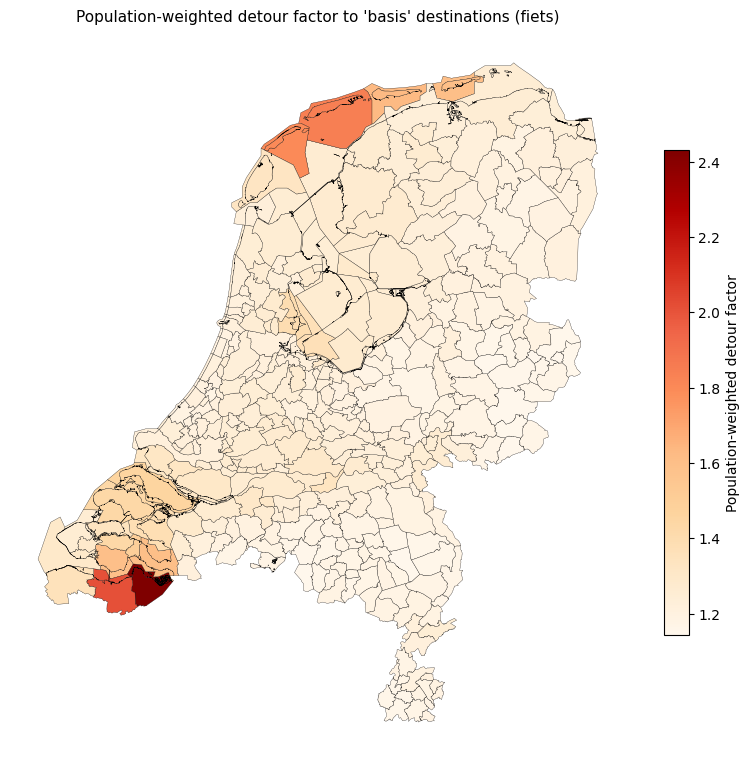

In [4]:


from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data.load_demographics import load_demograhics


# ─────────────────────────────────────────────────────────────────────────────
def load_municipality_geometry(gpkg_path: Path) -> gpd.GeoDataFrame:
    """Return GeoDataFrame with columns ['gm_naam', 'geometry']."""
    gdf = gpd.read_file(gpkg_path, layer="gemeenten")
    if "gemeentenaam" not in gdf.columns:
        raise ValueError("'gemeentenaam' column not found in 'gemeenten' layer")
    gdf = gdf[["gemeentenaam", "geometry"]].rename(columns={"gemeentenaam": "gm_naam"})
    gdf["gm_naam"] = gdf["gm_naam"].str.title()
    return gdf


def weighted_detour_by_municipality(trips: pd.DataFrame,
                                    demo:  pd.DataFrame) -> pd.DataFrame:
    """
    Population-weighted mean detour factor per municipality.
    Returns DataFrame ['gm_naam', 'pop_weighted_detour'].
    """
    merged = (
        trips.merge(
            demo[["gwb_code", "gm_naam", "a_inw"]],
            left_on="bu_code", right_on="gwb_code",
            how="left", validate="many_to_one")
          .dropna(subset=["a_inw"])
    )

    w = (
        merged.groupby("gm_naam")
              .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum()
                               / x["a_inw"].sum())
              .reset_index(name="pop_weighted_detour")
    )
    w["gm_naam"] = w["gm_naam"].str.title()
    return w


def main(
    category: str = "trein",
    modes: tuple[str, ...] = ("fiets",),
    gpkg:   Path = Path("data/wijkenbuurten_2023_v2.gpkg"),
    out_csv: Path = Path("detour_result.csv"),
    top_n: int = 20,
    make_map: bool = True,
) -> None:
    # 1. load trip tables
    matrices = read_all_punt_to_punt([category], list(modes))
    if not matrices:
        raise FileNotFoundError("No matching punt→buurt files found")
    trips = pd.concat(matrices.values(), ignore_index=True)

    # 2. load demographics & compute statistics
    demo = load_demograhics()
    det  = weighted_detour_by_municipality(trips, demo)
    det.to_csv(out_csv, index=False)
    print(f"CSV saved → {out_csv}")
    print(det.nlargest(top_n, "pop_weighted_detour"))

    # 3. map
    if make_map:
        gdf = load_municipality_geometry(gpkg).merge(det, on="gm_naam", how="left")
        ax = gdf.plot(
            column="pop_weighted_detour",
            cmap="OrRd",
            linewidth=0.2,
            edgecolor="black",
            figsize=(8, 10),
            legend=True,
            #make legend smaller
            legend_kwds={"label": "Population-weighted detour factor", "shrink": 0.5},
            missing_kwds={"color": "lightgrey", "label": "No data"},
        )
        ax.set_title(
            f"Population-weighted detour factor to '{category}' "
            f"destinations ({', '.join(modes)})",
            fontsize=11)
        ax.axis("off")
        plt.tight_layout()
        plt.savefig(
            f"Results/detour_map_{category}_{'_'.join(modes)}.png",
            dpi=300, bbox_inches="tight")
        plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# Auto-run in notebooks / IPython
if "__file__" not in globals():
    main(
        category="basis",
        modes=("fiets",),
        gpkg=Path("data/wijkenbuurten_2023_v2.gpkg"),
        out_csv=Path("detour_trein_fiets.csv"),
    )


## Calculate for popluation > value

Loaded file from CSV


C:\Users\david\AppData\Local\Temp\ipykernel_2548\1611565074.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum() / x["a_inw"].sum())


Saved CSV → detour_result.csv


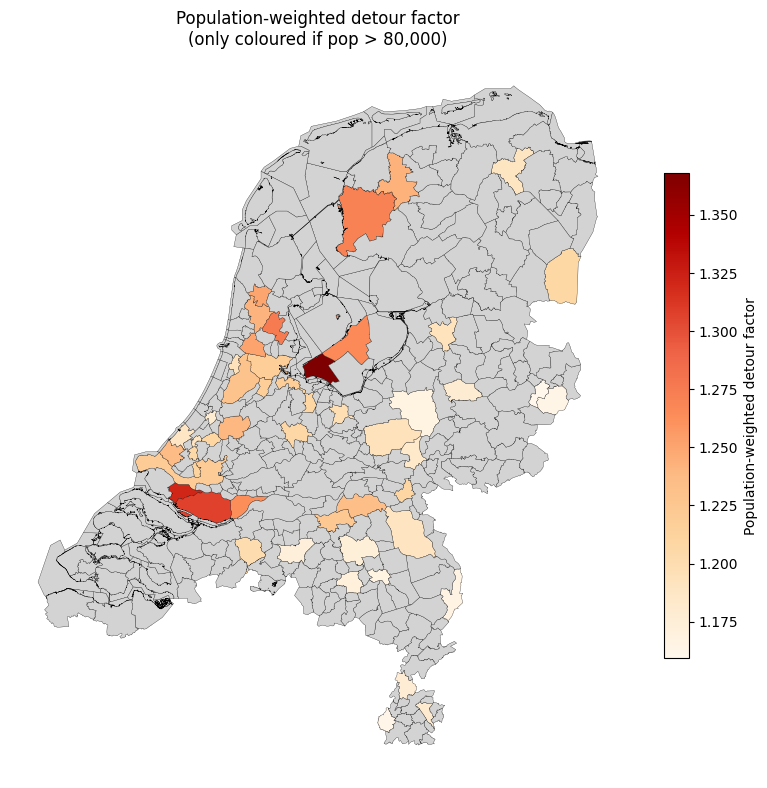

In [40]:
import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data.load_demographics import load_demograhics

def load_municipality_geometry(gpkg_path: Path) -> gpd.GeoDataFrame:
    gdf = gpd.read_file(gpkg_path, layer="gemeenten")
    gdf = (
        gdf[["gemeentenaam", "aantal_inwoners", "geometry"]]
        .rename(columns={"gemeentenaam": "gm_naam", "aantal_inwoners": "population"})
    )
    gdf["gm_naam"] = gdf["gm_naam"].str.title()
    return gdf

def weighted_detour_by_municipality(trips: pd.DataFrame, demo: pd.DataFrame) -> pd.DataFrame:
    merged = (
        trips
        .merge(demo[["gwb_code", "gm_naam", "a_inw"]],
               left_on="bu_code", right_on="gwb_code",
               how="left", validate="many_to_one")
        .dropna(subset=["a_inw"])
    )

    df_det = (
        merged.groupby("gm_naam")
              .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum() / x["a_inw"].sum())
              .reset_index(name="pop_weighted_detour")
    )
    df_det["gm_naam"] = df_det["gm_naam"].str.title()
    return df_det

def plot_detour_map(gdf: gpd.GeoDataFrame, pop_thresh: int):
    # mask out those below threshold, but keep geometry
    gdf["plot_detour"] = gdf["pop_weighted_detour"].where(gdf["population"] > pop_thresh)

    ax = gdf.plot(
        column="plot_detour",
        cmap="OrRd",
        edgecolor="black",
        linewidth=0.2,
        figsize=(8, 10),
        legend=True,
        legend_kwds={"label": "Population-weighted detour factor", "shrink": 0.5},
        missing_kwds={"color": "lightgrey", "label": f"pop ≤ {pop_thresh:,}"},
    )
    ax.set_title(
        f"Population-weighted detour factor\n"
        f"(only coloured if pop > {pop_thresh:,})",
        fontsize=12
    )
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(
        f"Results/detour_map_{pop_thresh}.png",
        dpi=300, bbox_inches="tight")
    plt.show()

def main(
            category: str = "basis",
    modes: tuple[str, ...] = ("fiets",),
    gpkg: Path = Path("data/wijkenbuurten_2023_v2.gpkg"),
    out_csv: Path = Path("detour_result.csv"),
    min_population: int = 80000,
):
    # 1. load and concat all punt→buurt files
    matrices = read_all_punt_to_punt([category], list(modes))
    trips = pd.concat(matrices.values(), ignore_index=True)

    # 2. compute detour
    demo = load_demograhics()
    det  = weighted_detour_by_municipality(trips, demo)
    det.to_csv(out_csv, index=False)
    print(f"Saved CSV → {out_csv}")

    # 3. load geometry and merge
    gdf = load_municipality_geometry(gpkg).merge(det, on="gm_naam", how="left")

    # 4. plot with mask
    plot_detour_map(gdf, min_population)

# auto-run in notebook
if "__file__" not in globals():
    main()


In [41]:
# Load the merged gdf if not already in memory
gdf = load_municipality_geometry(Path("data/wijkenbuurten_2023_v2.gpkg")).merge(
    pd.read_csv("detour_result.csv"), on="gm_naam", how="left"
)

# Filter to municipalities with population > 80,000
gdf_big = gdf[gdf["population"] > 80_000].copy()

# Remove NaNs if any
gdf_big = gdf_big.dropna(subset=["pop_weighted_detour"])

# Get Top 10 by detour factor
top_10 = gdf_big.sort_values("pop_weighted_detour", ascending=False).head(10)

# Print results
print("Top 10 municipalities (population > 80,000) with highest detour factor:")
for i, row in enumerate(top_10.itertuples(index=False), 1):
    print(f"{i}. {row.gm_naam}: detour={row.pop_weighted_detour:.3f}, population={int(row.population):,}")


Top 10 municipalities (population > 80,000) with highest detour factor:
1. Almere: detour=1.368, population=222,825
2. Nissewaard: detour=1.321, population=86,833
3. Hoeksche Waard: detour=1.308, population=89,760
4. Purmerend: detour=1.275, population=93,992
5. Súdwest-Fryslân: detour=1.271, population=90,883
6. Lelystad: detour=1.266, population=83,033
7. Dordrecht: detour=1.263, population=121,434
8. Zaanstad: detour=1.251, population=159,618
9. Dijk En Waard: detour=1.250, population=88,985
10. Leeuwarden: detour=1.243, population=127,073


 ## Zoom in on municipalities with highest detour factor

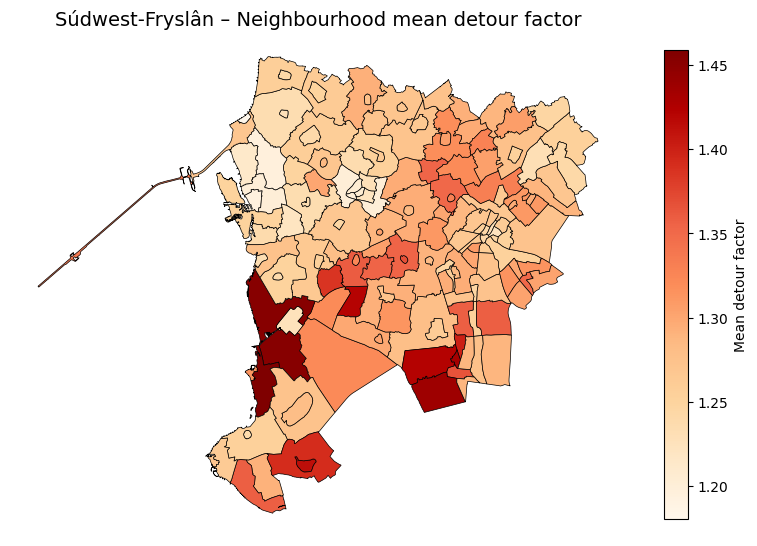

In [47]:
# --- Step 1: Filter to the right city
TARGET_MUN = "Súdwest-Fryslân"  #
buurtcodes_terneuzen = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN]["buurtcode"].unique()
trips_terneuzen = trips[trips["bu_code"].isin(buurtcodes_terneuzen)].copy()
demo_terneuzen = demo[demo["gwb_code"].isin(buurtcodes_terneuzen)].copy()

# --- Step 2: Compute detour for these buurten
neigh_detour = (
    trips_terneuzen.merge(
        demo_terneuzen[["gwb_code", "a_inw"]],
        left_on="bu_code", right_on="gwb_code",
        how="left")
    .groupby("gwb_code", as_index=False)
    .agg(mean_detour=("omrijdfactor", "mean"),
         population=("a_inw", "first"))
)

# --- Step 3: Rename and merge as before
neigh_detour_renamed = neigh_detour.rename(columns={'gwb_code': 'buurtcode'})
gdf_mun = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN].copy()
gdf_mun = gdf_mun.merge(neigh_detour_renamed, on="buurtcode", how="left")

# --- Step 4: Plot
fig, ax = plt.subplots(figsize=(8, 7))
gdf_mun.plot(
    column="mean_detour",
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "Mean detour factor", "shrink": 0.7},
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)
ax.set_title(f"{TARGET_MUN} – Neighbourhood mean detour factor", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.savefig(f"Results/detour_map_{TARGET_MUN}.png", dpi=300, bbox_inches="tight")
plt.show()


Mean detour factor per neighbourhood (gwb_code) in Amsterdam


,gwb_code,mean_detour,population
0,BU0363NQ08,1.554082,285.0
1,BU0363BA02,1.543913,5.0
2,BU0363MK01,1.442400,0.0
3,BU0363BB01,1.363469,175.0
4,BU0363SB02,1.342037,105.0
...,...,...,...
511,BU0363AF02,1.165283,1100.0
512,BU0363AD03,1.162264,505.0
513,BU0363AA06,1.159615,1515.0
514,BU0363AA05,1.157692,2375.0


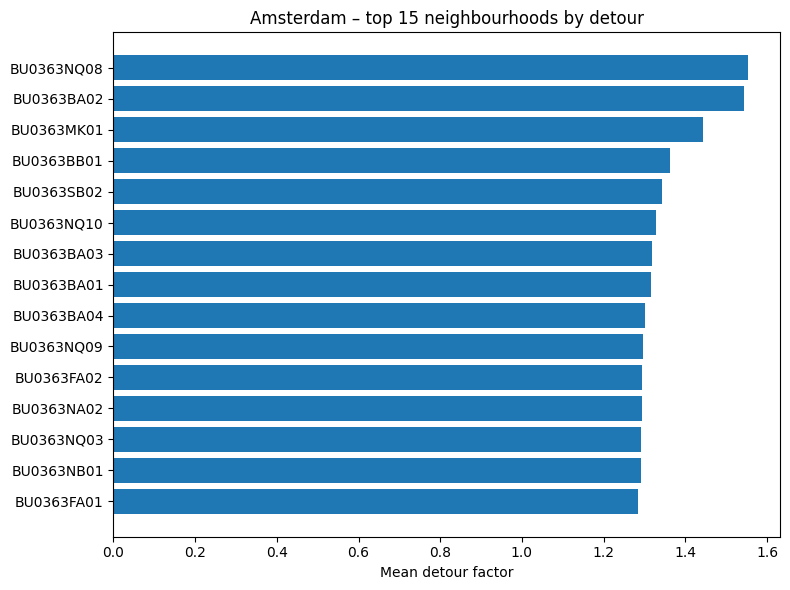

In [18]:
# ------------------------------------------------------------------
# Build all prerequisite variables used later: trips, demo, det, gdf
# ------------------------------------------------------------------
from pathlib import Path
import pandas as pd
import geopandas as gpd
from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data.load_demographics import load_demograhics

# a. parameters
CATEGORY = "trein"
MODES    = ("fiets",)
GPKG     = Path("data/wijkenbuurten_2023_v2.gpkg")

# b. trips
matrices = read_all_punt_to_punt([CATEGORY], list(MODES))
trips    = pd.concat(matrices.values(), ignore_index=True)

# c. demo
demo = load_demograhics()

# d. detour per gemeente
det = weighted_detour_by_municipality(trips, demo)

# e. geometry + merge
gdf = load_municipality_geometry(GPKG).merge(det, on="gm_naam", how="left")

print("Ready: trips, demo, det, gdf")
gdf_neigh = gpd.read_file("data/wijkenbuurten_2023_v2.gpkg", layer="buurten")  # or "buurt" or "wijk"
# inspect columns:
print(gdf_neigh.columns)

# We'll assume there is a 'gwb_code' and 'gm_naam' column in gdf_neigh

TARGET_MUN = "Terneuzen"  # or any gm_naam you want

# Filter to only neighbourhoods in the selected municipality
gdf_mun = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN].copy()

# Merge with detour factors
gdf_mun = gdf_mun.merge(neigh_detour, on="gwb_code", how="left")
